In [58]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from urllib.parse import urljoin
import numpy as np
from os.path import dirname
from jinja2 import Template
import itertools
from collections import defaultdict
import random
from IPython.display import Image, display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

%matplotlib inline

In [59]:
def load_json(in_file_path):
    with open(in_file_path) as f:
        data = json.load(f)
        return data

In [60]:
PREDICTION_TYPE_TRUE_NEGATIVE = "true_negative"
PREDICTION_TYPE_TRUE_POSITIVE = "true_positive"
PREDICTION_TYPE_FALSE_NEGATIVE = "false_negative"
PREDICTION_TYPE_FALSE_POSITIVE = "false_positive"

BUCKET_TYPE_TOP = "top"
BUCKET_TYPE_MID = "mid"
BUCKET_TYPE_BOTTOM = "bottom"

BUCKET_TYPE_TOP_VALUE = 0.66
BUCKET_TYPE_MID_VALUE = 0.33
BUCKET_TYPE_BOTTOM_VALUE = 0.0

PREDICTION_TYPES = [PREDICTION_TYPE_TRUE_NEGATIVE, PREDICTION_TYPE_TRUE_POSITIVE, PREDICTION_TYPE_FALSE_NEGATIVE, PREDICTION_TYPE_FALSE_POSITIVE]
BUCKET_TYPES = [BUCKET_TYPE_TOP, BUCKET_TYPE_MID, BUCKET_TYPE_BOTTOM]

In [79]:
class ClassPredictions:
    
    def __init__(self, class_name, class_ix):
        self.class_name = class_name
        self.class_ix = class_ix
        self.predictions_by_type = defaultdict(list)
    
    def add_prediction(self, prediction):
        predicted_class_ix = prediction["yi_pred_ix"]
        yi_true = prediction["yi_true"]
        
        true_class_ix = np.argmax(yi_true)
        
        if (self.class_ix == predicted_class_ix) and (predicted_class_ix == true_class_ix):
            prediction_type = PREDICTION_TYPE_TRUE_POSITIVE
            
        elif (self.class_ix == predicted_class_ix) and (predicted_class_ix != true_class_ix):
            prediction_type = PREDICTION_TYPE_FALSE_POSITIVE
            
        elif (self.class_ix != predicted_class_ix) and (self.class_ix != true_class_ix):
            prediction_type = PREDICTION_TYPE_TRUE_NEGATIVE
        
        elif (self.class_ix != predicted_class_ix) and (self.class_ix == true_class_ix):
            prediction_type = PREDICTION_TYPE_FALSE_NEGATIVE
        
        prediction["prediction_type"] = prediction_type
        self.predictions_by_type[prediction_type].append(prediction)
        
    def get_predictions_by_type(self, prediction_type, bucket_type):
        predictions = self.predictions_by_type[prediction_type]
        
        if bucket_type == BUCKET_TYPE_TOP:
            predictions = [prediction for prediction in predictions if max(prediction["yi_proba"]) >= BUCKET_TYPE_TOP_VALUE]
        elif bucket_type == BUCKET_TYPE_MID:
            predictions = [prediction for prediction in predictions if max(prediction["yi_proba"]) >= BUCKET_TYPE_MID_VALUE and max(prediction["yi_proba"]) <= BUCKET_TYPE_TOP_VALUE]
        else:
            predictions = [prediction for prediction in predictions if max(prediction["yi_proba"]) <= BUCKET_TYPE_BOTTOM_VALUE]
        
        return predictions
        

In [95]:
def get_bucketed_predictions(predictions, class_map):
    class_predictions = dict()
    
    for class_name, class_ix in class_map.items():
        class_predictions[class_name] = ClassPredictions(class_name, class_ix)
    
    for prediction in predictions:
        for class_name in class_map.keys():
            class_predictions[class_name].add_prediction(prediction)
    
    return class_predictions
        

In [63]:
def load_jsonl(in_file_path):
    with open(in_file_path) as f:
        data = map(json.loads, f)
        for datum in data:
            yield datum

In [96]:
def plot_prediction_distributions(class_evaluation_data, class_name):
    plt.rcParams["figure.figsize"] = (20,5)
    plt.hist(class_evaluation_data['y_proba'], alpha=0.7)
    title = '%s | Prediction Distribution' % (class_name)
    plt.title(title)
    plt.xlabel('y_proba')
    plt.ylabel('count')
    plt.show()

In [65]:
def load_template(tpl_name):
    with open(tpl_name) as f:
        return Template(f.read())

In [77]:
def render_template(template, sample):
    x = sample["xi"]
    guid = sample.get("guid", os.path.basename(x))
    prediction = max(sample["yi_proba"])
    
    if is_image_path(x):
        image_path = os.path.join("images", os.path.basename(x))
        text = None
    else:
        image_path = None
        text = x
    
    html = template.render(dict(sample=dict(guid=guid, prediction=prediction, image_url=image_path, text=text)))
    return html

In [67]:
def is_image_path(data):
    return True

In [87]:
evaluation_data_fp ="/Users/jnewman/Projects/learning/complete-ai/ai/blog_post_visualize_performance/training_runs/mnist_keras_cnn_embedding_experiment/1551584828.1162791/mnist_keras_cnn_embedding_experiment_evaluation_data_path.json"
prediction_fp = "/Users/jnewman/Projects/learning/complete-ai/ai/blog_post_visualize_performance/training_runs/mnist_keras_cnn_embedding_experiment/1551584828.1162791/mnist_keras_cnn_embedding_experiment_test_data_predictions.jsonl"
class_map_fp = "/Users/jnewman/Projects/learning/complete-ai/ai/blog_post_visualize_performance/training_runs/mnist_keras_cnn_embedding_experiment/1551584828.1162791/mnist_keras_cnn_embedding_experiment_class_map.json"

In [89]:
predictions = list(load_jsonl(prediction_fp))
class_map = load_json(class_map_fp)
evaluation_data = load_json(evaluation_data_fp)
inverted_class_map = {ix: class_name for class_name, ix in class_map.items()}
CLASSES = list(class_map.keys())
template = load_template("sample_template.html")

In [82]:
class_predictions_dict = get_bucketed_predictions(predictions, class_map)

In [83]:
sample_slider_widget = widgets.IntSlider(min=0,max=100,step=1,value=0)

In [84]:
def plot_interactive_predictions(class_name, ix, prediction_type, bucket_type):
    print(prediction_type, bucket_type)
    class_predictions = class_predictions_dict[class_name]
    predictions = class_predictions.get_predictions_by_type(prediction_type=prediction_type, bucket_type=bucket_type)
    num_samples = len(predictions)
    
    if ix >= num_samples:
        ix = num_samples - 1
    
    sample = predictions[ix]

    html = render_template(template, sample=sample)
    display(HTML(html))

dict_keys(['coin_toss_data', 'category_metrics', 'confusion_matrix'])


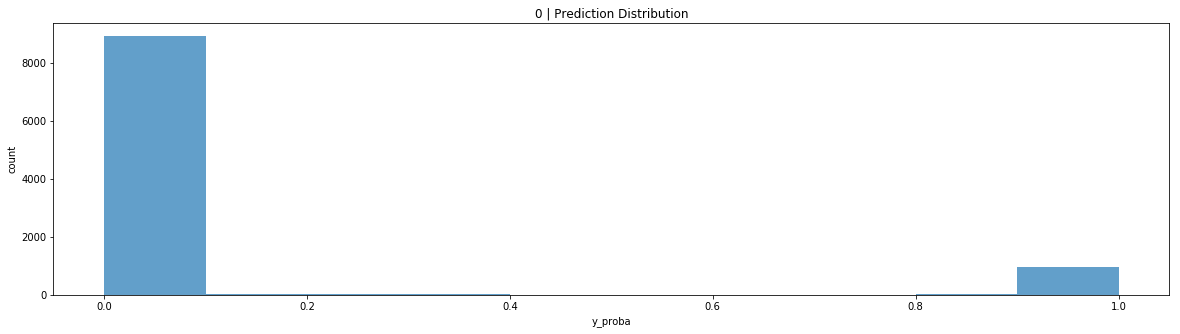

In [97]:
print(evaluation_data.keys())
plot_prediction_distributions(evaluation_data["category_metrics"]["0"], "0")

In [85]:
interact(plot_interactive_predictions, class_name=CLASSES, bucket_type=BUCKET_TYPES, prediction_type=PREDICTION_TYPES, ix=sample_slider_widget)

interactive(children=(Dropdown(description='class_name', options=('0', '1', '2', '3', '4', '5', '6', '7', '8',…

<function __main__.plot_interactive_predictions(class_name, ix, prediction_type, bucket_type)>